OPTIMIZED HYPERPARAMETER TUNING FOR PREDICTIVE MAINTENANCE

 Data ready — Training samples: 3102, Test samples: 400

 Tuning Random Forest...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
 Random Forest done in 27.03s — Test F1: 0.6667, Accuracy: 0.9750
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       388
           1       0.56      0.83      0.67        12

    accuracy                           0.97       400
   macro avg       0.78      0.91      0.83       400
weighted avg       0.98      0.97      0.98       400


 Tuning Gradient Boosting...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
 Gradient Boosting done in 15.18s — Test F1: 0.7692, Accuracy: 0.9850
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       388
           1       0.71      0.83      0.77        12

    accuracy                           0.98       400
   macro avg       0.85  

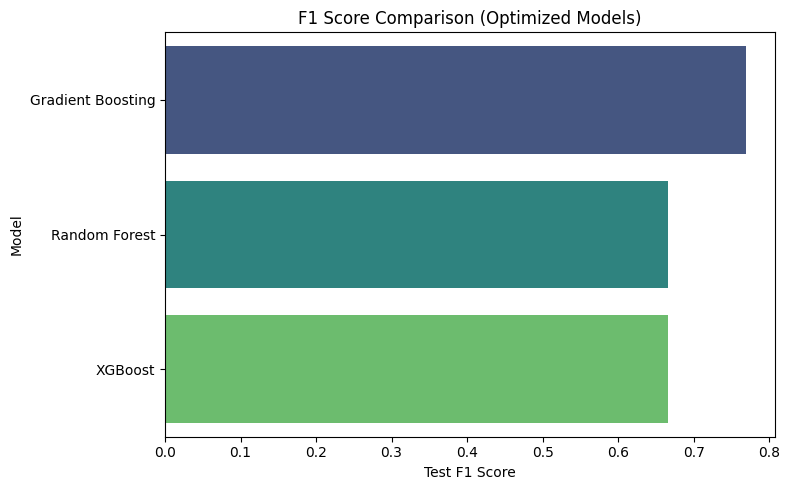

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import time
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

# =============================================
# 1. LOAD AND PREPARE DATA
# =============================================
print("="*70)
print("OPTIMIZED HYPERPARAMETER TUNING FOR PREDICTIVE MAINTENANCE")
print("="*70)

start_global = time.time()

df = pd.read_csv("ai4i2020_small.csv")

# --- Feature engineering ---
df["temp_diff"] = df["Process temperature [K]"] - df["Air temperature [K]"]
df["power"] = df["Torque [Nm]"] * df["Rotational speed [rpm]"] / 1000
df["torque_speed_ratio"] = df["Torque [Nm]"] / (df["Rotational speed [rpm]"] + 1)
df["temp_torque_interaction"] = df["Process temperature [K]"] * df["Torque [Nm]"]

features = [
    "Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]",
    "Torque [Nm]", "Tool wear [min]", "temp_diff", "power",
    "torque_speed_ratio", "temp_torque_interaction"
]
target = "Machine failure"

X = df[features]
y = df[target]

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Scaling + SMOTE ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\n Data ready — Training samples: {len(X_train_resampled)}, Test samples: {len(X_test)}")

# =============================================
# 2. PARAMETER GRIDS (Smaller but Effective)
# =============================================
rf_params = {
    "n_estimators": [200, 300, 400],
    "max_depth": [10, 15, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
}

gb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
}

xgb_params = {
    "n_estimators": [200, 300],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "gamma": [0, 0.1],
    "min_child_weight": [1, 3],
    "scale_pos_weight": [len(y_train[y_train==0]) / len(y_train[y_train==1])],
}

# =============================================
# 3. TUNING FUNCTION
# =============================================
def tune_model(model, param_grid, name, n_iter=25):
    print(f"\n Tuning {name}...")
    start_time = time.time()
    scorer = make_scorer(f1_score)

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring=scorer,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train_resampled, y_train_resampled)
    y_pred = search.best_estimator_.predict(X_test_scaled)

    elapsed = time.time() - start_time
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f" {name} done in {elapsed:.2f}s — Test F1: {f1:.4f}, Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    return {
        "Model": name,
        "Estimator": search.best_estimator_,
        "Best Params": search.best_params_,
        "CV F1": search.best_score_,
        "Test Accuracy": acc,
        "Test F1": f1,
        "Time": elapsed
    }

# =============================================
# 4. RUN TUNING
# =============================================
results = []
models = [
    ("Random Forest", RandomForestClassifier(random_state=42, n_jobs=-1), rf_params),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42), gb_params),
    ("XGBoost", XGBClassifier(random_state=42, eval_metric="logloss"), xgb_params),
]

for name, model, grid in models:
    results.append(tune_model(model, grid, name))

# =============================================
# 5. RESULTS COMPARISON
# =============================================
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("Test F1", ascending=False)
best = df_results.iloc[0]

print("\n" + "="*70)
print(" TUNING SUMMARY")
print(df_results[["Model", "CV F1", "Test Accuracy", "Test F1", "Time"]])
print("="*70)
print(f" Best Model: {best['Model']}")
print(f"Test F1 Score: {best['Test F1']:.4f}")
print(f"Accuracy: {best['Test Accuracy']:.4f}")

# =============================================
# 6. SAVE RESULTS
# =============================================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pickle.dump(best["Estimator"], open(f"best_model_{timestamp}.pkl", "wb"))
df_results.to_csv(f"tuning_summary_{timestamp}.csv", index=False)
print(f"\n Best model and results saved with timestamp {timestamp}")

# =============================================
# 7. VISUALIZATION
# =============================================
plt.figure(figsize=(8, 5))
sns.barplot(data=df_results, x="Test F1", y="Model", palette="viridis")
plt.title("F1 Score Comparison (Optimized Models)")
plt.xlabel("Test F1 Score")
plt.tight_layout()
plt.savefig(f"optimized_tuning_{timestamp}.png", dpi=300)
print(f" Visualization saved as optimized_tuning_{timestamp}.png")

print("\n All done in {:.2f} seconds total!".format(time.time() - start_global))


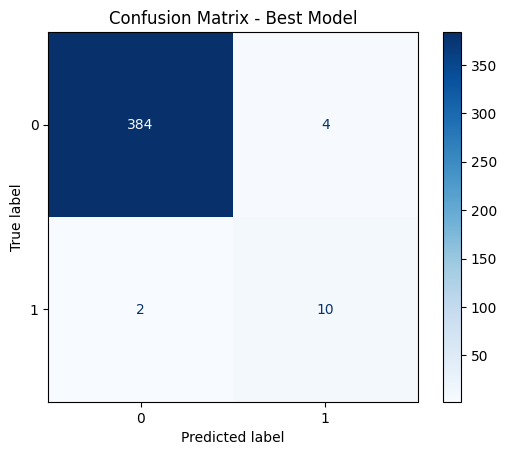

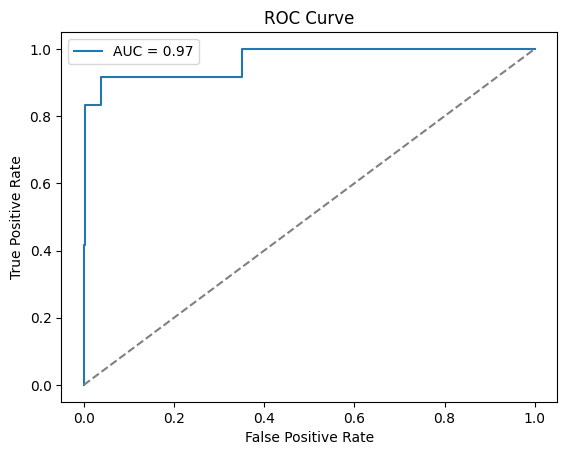

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import pickle

# Load best saved model
best_model = pickle.load(open("best_model_20251105_220454.pkl", "rb"))

# Predict on test set
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Best Model")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


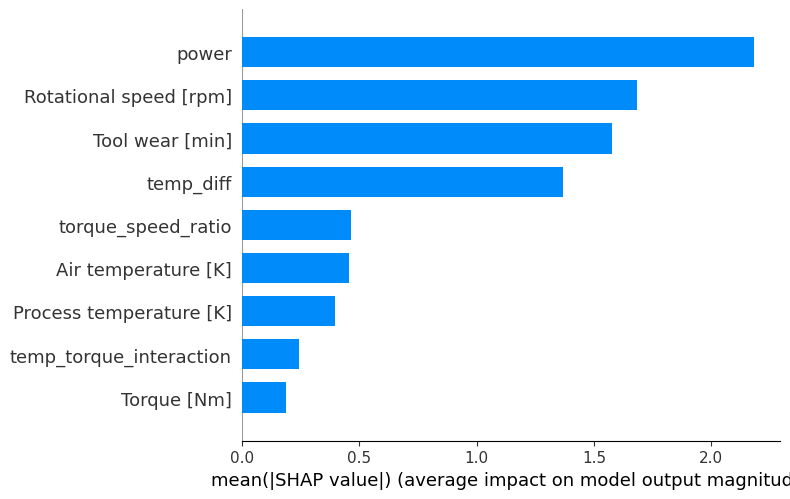

In [8]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_scaled)

# Global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [12]:
import pandas as pd

df_results = pd.read_csv("tuning_summary_20251105_220454.csv")
df_results.sort_values("Test F1", ascending=False)


,Model,Estimator,Best Params,CV F1,Test Accuracy,Test F1,Time
0,Gradient Boosting,"GradientBoostingClassifier(max_depth=5, n_esti...","{'subsample': 0.8, 'n_estimators': 200, 'max_d...",0.978300,0.9850,0.769231,15.181308
1,Random Forest,"RandomForestClassifier(max_depth=20, n_estimat...","{'n_estimators': 300, 'min_samples_split': 2, ...",0.976783,0.9750,0.666667,27.031137
2,XGBoost,"XGBClassifier(base_score=None, booster=None, c...","{'subsample': 0.7, 'scale_pos_weight': 31.6530...",0.972689,0.9725,0.666667,5.060695


In [13]:
import pickle

final_model = best["Estimator"]
pickle.dump(final_model, open("final_predictive_maintenance_model.pkl", "wb"))
print("✅ Final model saved as 'final_predictive_maintenance_model.pkl'")


✅ Final model saved as 'final_predictive_maintenance_model.pkl'
